In [12]:
%load_ext autoreload
%autoreload 2

In [1]:
from os.path import join as opj
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [2]:
data_root = '/om2/user/rogerjin/data'
data_path = opj(data_root, 'data_files_new.npz')
data = np.load(data_path)
rna = data['rna_train']
atac = data['atac_train_small']

In [3]:
def zero_frac(arr):
    zero_count = np.count_nonzero(arr==0)
    return zero_count/arr.size

In [4]:
print('rna zero frac:', zero_frac(rna))
print('atac zero frac:', zero_frac(atac))

rna zero frac: 0.0
atac zero frac: 0.9740022531413609


In [5]:
list(data.keys())

['peak_selector',
 'atac_train_small',
 'atac_test_small',
 'rna_train',
 'rna_test',
 'rna_good_feats',
 'train_idx',
 'test_idx',
 'cell_type_train',
 'cell_type_test']

In [6]:
import torch
torch.cuda.is_available()

True

In [7]:
import pandas as pd
gene_list = pd.read_csv(f'{data_root}/gene_list.csv', header=None)

In [8]:
chosen_genes = gene_list[data['rna_good_feats']]

In [9]:
from os.path import join as opj
import numpy as np

data_root = '/om2/user/rogerjin/data'
data_path = opj(data_root, 'data_files_new.npz')
data = np.load(data_path, allow_pickle=True)
cell_labels_train = data['cell_type_train']

In [10]:
cell_labels_train.shape

(6897,)

In [11]:
from GanoliModel import GanoliPCAGAN
model_cls = GanoliPCAGAN

Global seed set to 42


In [29]:
train_rna = data['rna_train']
train_atac = data['atac_train_small']
val_rna = data['rna_test']
val_atac = data['atac_test_small']

rna_val_labels = data['cell_type_test']

In [21]:
def transform_tfidf(matrix, device='cuda:0'):
    # `matrix` is a `|V| x |D|` matrix of raw counts, where `|V|` is the 
    # vocabulary size and `|D|` is the number of documents in the corpus. This
    # function should (nondestructively) return a version of `matrix` with the
    # TF-IDF transform appliied.

    # Your code here!
    matrix = torch.Tensor(matrix).to(device)
    matrix = matrix.T
    v,d = matrix.shape
    present = matrix > 0
    contain = torch.sum(present, axis=1, keepdims=True)
    zero = contain==0
    idf = torch.log(d/contain)
    tfidf = matrix * idf
    return tfidf.T

In [26]:
val_rna_tfidf = transform_tfidf(val_rna)

In [27]:
val_rna_tfidf.shape

torch.Size([2300, 7445])

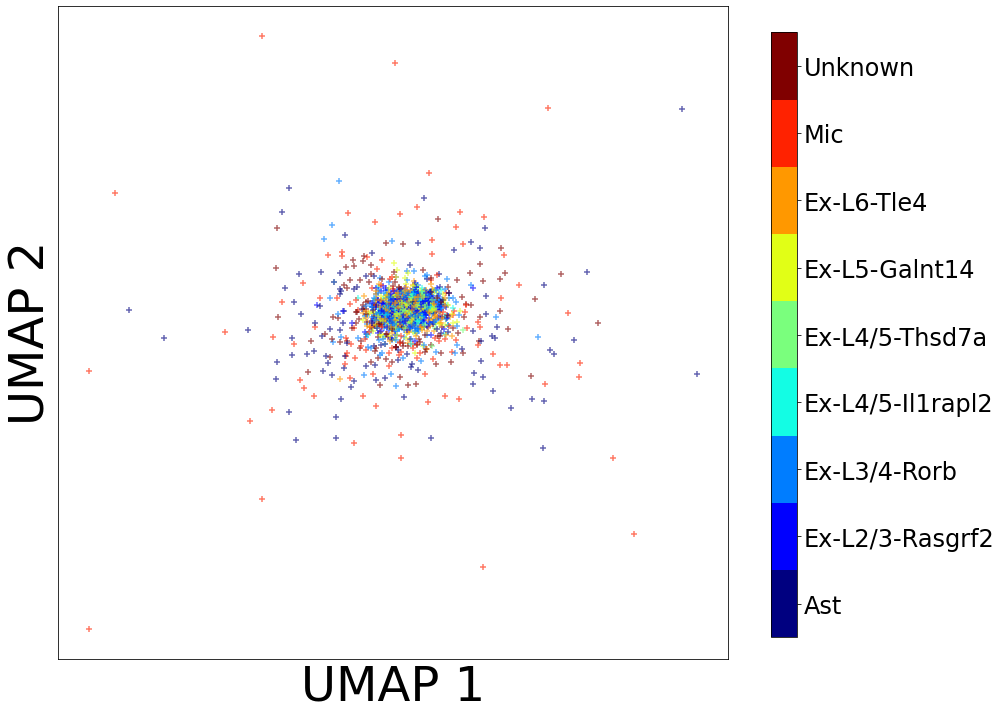

In [45]:
from sklearn.decomposition import PCA
import umap
import benplot

reducer = umap.UMAP(densmap=True)
pca = PCA(n_components=30)
val_rna_pca = pca.fit_transform(val_rna)
# val_rna_pca = pca.fit_transform(val_rna_tfidf.detach().cpu().numpy())
val_rna_umap = reducer.fit_transform(val_rna_pca)
benplot.plot_lowdim_rep(rna_umap_feats, rna_val_labels)

In [33]:
pca = PCA(n_components=2) 

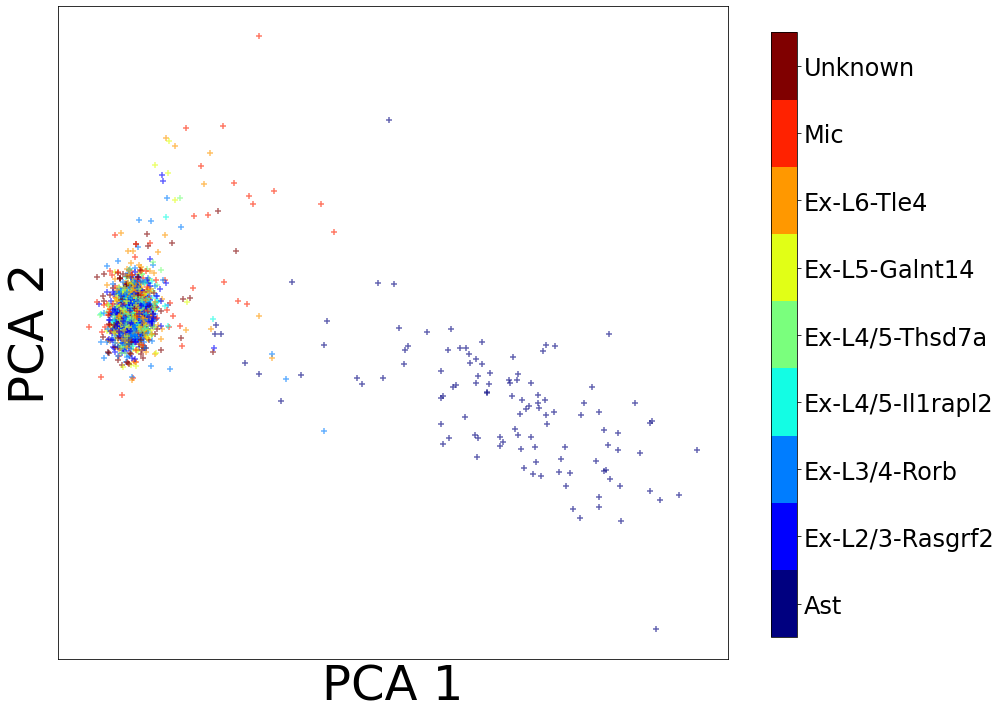

In [36]:
val_rna_tfidf_pca = pca.fit_transform(val_rna_tfidf.detach().cpu().numpy())
benplot.plot_lowdim_rep(val_rna_tfidf_pca, rna_val_labels, xlabel='PCA 1', ylabel='PCA 2')

In [13]:
from sklearn.decomposition import PCA

train_rna = data['rna_train']
train_atac = data['atac_train_small']
pca_rna = PCA(n_components=20)
pca_atac = PCA(n_components=20)
pca_rna.fit_transform(train_rna)
pca_atac.fit_transform(train_atac)
rna_embedding = torch.Tensor(pca_rna.components_.T).to('cuda:0')
atac_embedding = torch.Tensor(pca_atac.components_.T).to('cuda:0')

KeyboardInterrupt: 

In [30]:
model = 'logistic_embed_pca_lr=0.0002_beta1=0.5'
version = 0
checkpoint = 'step=30671-epoch=141-val_oracle_total=1.11.ckpt'

checkpoint_dir = f'/om2/user/rogerjin/GANOLI/ganoli/models/logs/{model}/default/version_{version}/checkpoints/'
checkpoint_path = f'{checkpoint_dir}/{checkpoint}'

In [31]:
ckpt_model = model_cls.load_from_checkpoint(checkpoint_path=checkpoint_path, rna_shape=7445, atac_shape=3808, rna_embedding=rna_embedding, atac_embedding=atac_embedding)

In [32]:
ckpt_model.to('cuda:0')

GanoliPCAGAN(
  (generator_rna2atac): GanoliLogisticGenerator(
    (linear): Linear(in_features=20, out_features=3808, bias=True)
    (sigmoid): Sigmoid()
  )
  (generator_atac2rna): GanoliLinearGenerator(
    (model): Linear(in_features=20, out_features=7445, bias=True)
  )
  (discriminator_rna): GanoliLinearDiscriminator(
    (model): Linear(in_features=20, out_features=1, bias=True)
  )
  (discriminator_atac): GanoliLinearDiscriminator(
    (model): Linear(in_features=20, out_features=1, bias=True)
  )
  (reconstruction_loss_fn): MSELoss()
  (identity_loss_fn): MSELoss()
  (generator_loss_fn): BCEWithLogitsLoss()
  (discriminator_loss_fn): BCEWithLogitsLoss()
)

In [33]:
atac_val = data['atac_test_small']

In [34]:
import torch
atac_val = torch.Tensor(atac_val).to('cuda:0')

In [35]:
atac_val_mini = atac_val[:10, :]

In [36]:
rna_val_pred = ckpt_model(atac_val,data_type='atac')

In [37]:
rna_val_pred.shape

torch.Size([2300, 7445])

In [38]:
rna_val_labels = data['cell_type_test']

In [39]:
import umap
reducer = umap.UMAP(densmap=True) 
rna_trans = reducer.fit_transform(rna_val_pred.detach().cpu().numpy())

In [40]:
rna_trans.shape

(2300, 2)

In [41]:
import benplot

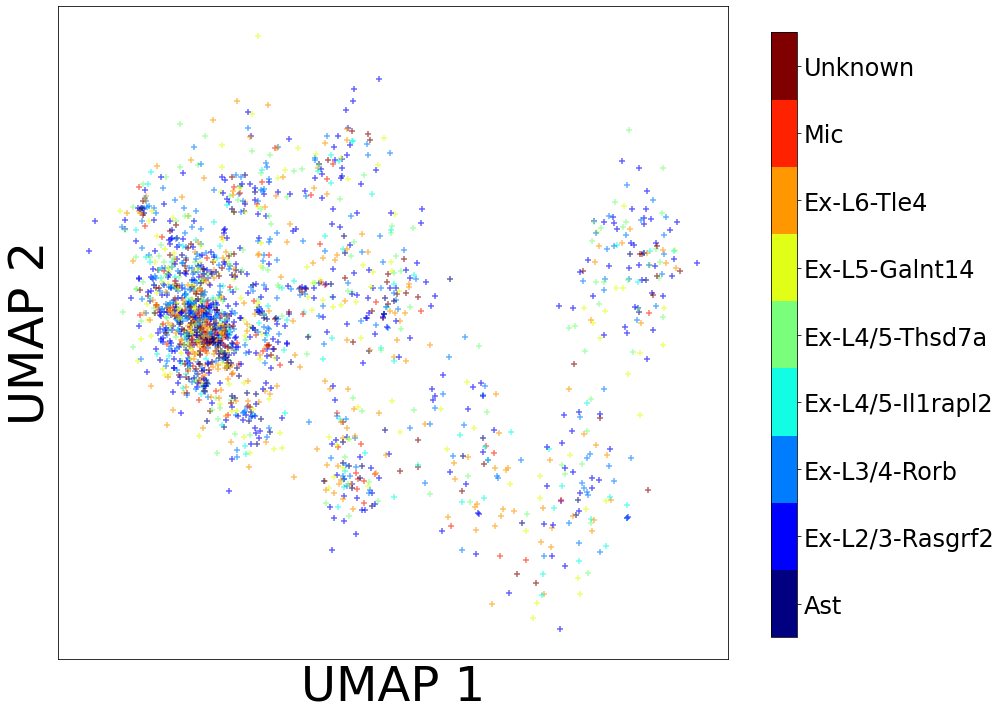

In [42]:
benplot.plot_lowdim_rep(rna_trans, rna_val_labels)

In [43]:
rna_val = data['rna_test']
reducer = umap.UMAP(densmap=True, min_dist=0.001) 
rna_true_trans = reducer.fit_transform(rna_val)

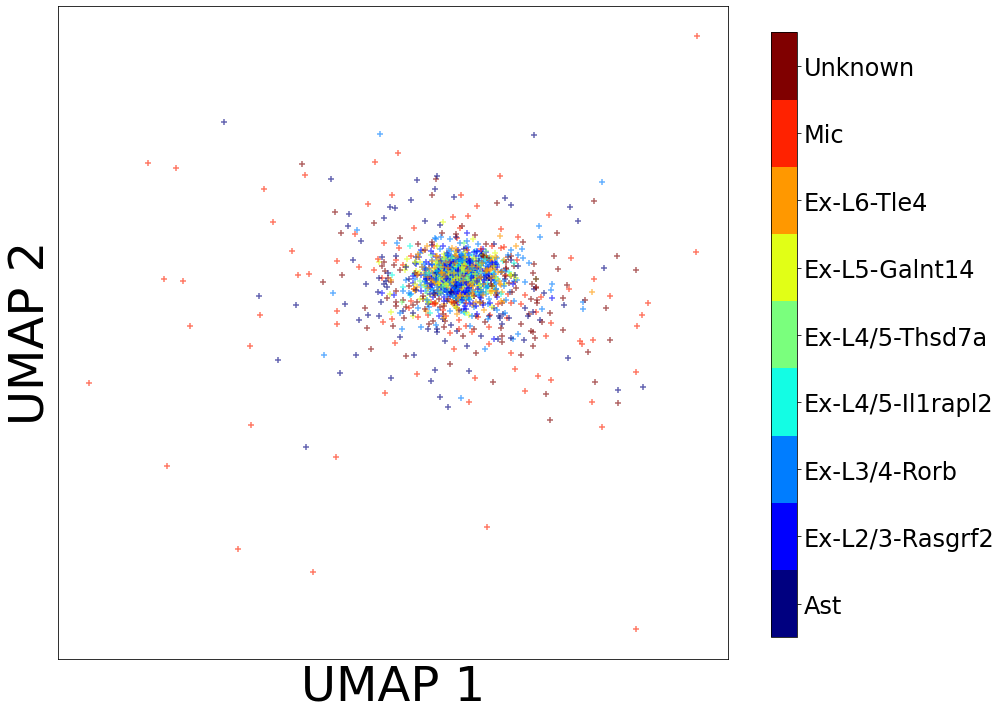

In [44]:
benplot.plot_lowdim_rep(rna_true_trans, rna_val_labels)

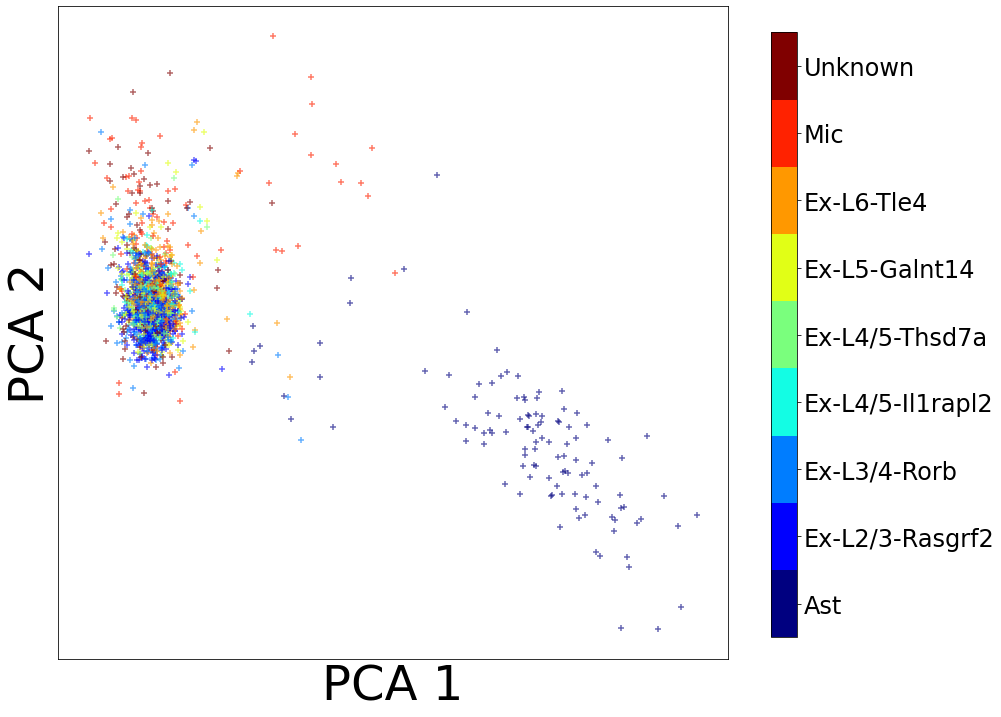

In [45]:
from sklearn.decomposition import PCA

rna_val = data['rna_test']
reducer = PCA(n_components=2) 
rna_true_trans = reducer.fit_transform(rna_val)
benplot.plot_lowdim_rep(rna_true_trans, rna_val_labels, xlabel='PCA 1', ylabel='PCA 2')

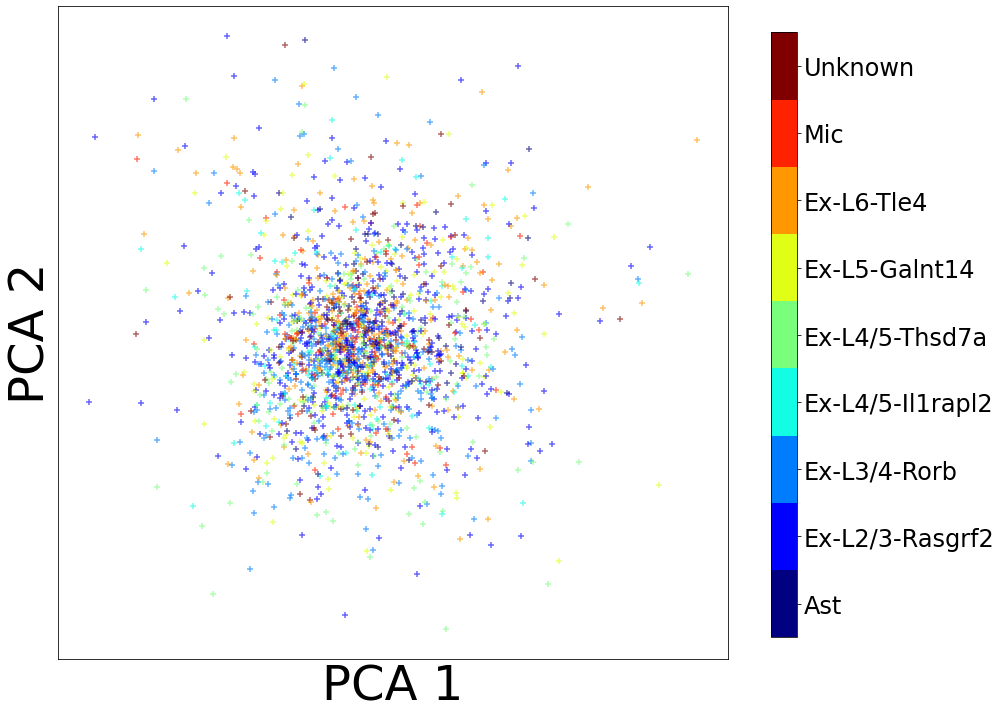

In [46]:
reducer = PCA(n_components=2) 
rna_pred_trans = reducer.fit_transform(rna_val_pred.detach().cpu().numpy())
benplot.plot_lowdim_rep(rna_pred_trans, rna_val_labels, xlabel='PCA 1', ylabel='PCA 2')

In [47]:
rna_val = torch.Tensor(rna_val).to('cuda:0')
atac_val_pred = ckpt_model(rna_val,data_type='rna')

In [48]:
atac_val_pred

tensor([[0.0064, 0.0213, 0.0551,  ..., 0.0088, 0.0047, 0.0102],
        [0.0081, 0.0191, 0.0272,  ..., 0.0125, 0.0060, 0.0112],
        [0.0224, 0.0274, 0.0160,  ..., 0.0230, 0.0176, 0.0212],
        ...,
        [0.0077, 0.0166, 0.0185,  ..., 0.0107, 0.0060, 0.0115],
        [0.0051, 0.0203, 0.0192,  ..., 0.0099, 0.0042, 0.0107],
        [0.0315, 0.0117, 0.0193,  ..., 0.0381, 0.0334, 0.0341]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [49]:
atac_val_pred

tensor([[0.0064, 0.0213, 0.0551,  ..., 0.0088, 0.0047, 0.0102],
        [0.0081, 0.0191, 0.0272,  ..., 0.0125, 0.0060, 0.0112],
        [0.0224, 0.0274, 0.0160,  ..., 0.0230, 0.0176, 0.0212],
        ...,
        [0.0077, 0.0166, 0.0185,  ..., 0.0107, 0.0060, 0.0115],
        [0.0051, 0.0203, 0.0192,  ..., 0.0099, 0.0042, 0.0107],
        [0.0315, 0.0117, 0.0193,  ..., 0.0381, 0.0334, 0.0341]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [50]:
type(atac_val)

torch.Tensor

In [51]:
from sklearn.metrics import roc_auc_score
import pandas as pd

aurocs = []
for i in range(atac_val.shape[1]):
    auroc = roc_auc_score(atac_val[:, i].detach().cpu().numpy(), atac_val_pred[:, i].detach().cpu().numpy())
    aurocs.append(auroc)

atac_rocs = pd.DataFrame()
atac_rocs['auroc'] = aurocs

array([[<AxesSubplot:title={'center':'auroc'}>]], dtype=object)

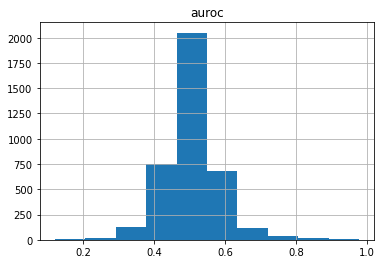

In [52]:
atac_rocs.hist()

In [53]:
atac_rocs.mean()

auroc    0.507003
dtype: float64